In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

In [2]:
#Avoid OOM errors by setting GPU Memory Consumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth (gpu, True) 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import pandas as pd

df = pd.read_csv('hourly_weather_data_labeled.csv')
df['time'] = pd.to_datetime(df['time'])

# Sort and reset index
df = df.sort_values(['city', 'time']).reset_index(drop=True)

# Select features and target
features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'windspeed_10m', 'city']
targets = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'windspeed_10m']

In [3]:
def create_sequences(data, input_len=120, output_len=120):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        x_seq = data[i : i + input_len]
        y_seq = data[i + input_len : i + input_len + output_len, :4]  # Only first 4 columns (features)
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)


In [4]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features])

# Save scaler
joblib.dump(scaler, 'model_2.pkl')

# Convert to sequences
X, y = create_sequences(data_scaled)
print("Input shape:", X.shape)  # (samples, 120, 5)
print("Output shape:", y.shape)  # (samples, 120, 4)


Input shape: (42990, 120, 5)
Output shape: (42990, 120, 4)


In [6]:
model = Sequential()
model.add(LSTM(128, input_shape=(120, 5), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(4)))  # Predict 4 features

model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])  # Explicitly use MeanSquaredError
model.summary()


c:\Users\Vignesh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 120, 64)        │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 120, 4)         │           260 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,436 (478.27 KB)

 Trainable params: 122,436 (478.27 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

model.save("model_2.h5")


Epoch 1/20
  54/1075 ━━━━━━━━━━━━━━━━━━━━ 2:33 151ms/step - loss: 0.0804 - mae: 0.2124

KeyboardInterrupt: 

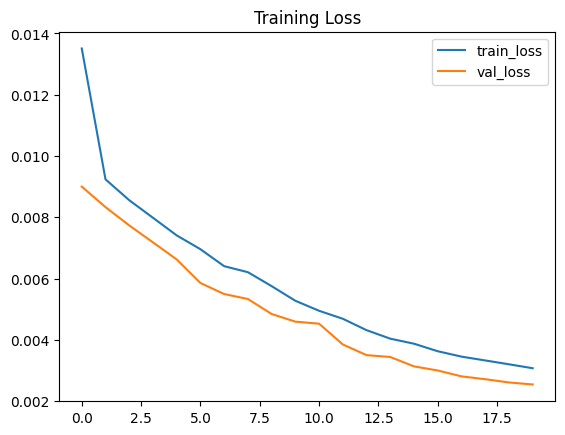

In [9]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.legend()
plt.show()

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
import joblib

# Load model & scaler
model = load_model("model_2_temp_hum_press.h5")
scaler = joblib.load("model_2_scaler.pkl")

# Assuming 'df' is already loaded with the necessary data
# And 'features' and 'targets' are defined (e.g., features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'windspeed_10m', 'city']; targets = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'windspeed_10m'])

# Get today's time at 00:00
today_time = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)

# Get latest 120 hours for a city (e.g., Chennai - city code 0)
city_df = df[df['city'] == 0].sort_values('time')
latest_120 = city_df[-120:][features]

# Scale and reshape
latest_scaled = scaler.transform(latest_120)
X_input = latest_scaled.reshape(1, 120, 5)

# Predict next 120 hours
predicted_scaled = model.predict(X_input)[0]

# Inverse scale: pad with dummy city code (we need 5 columns)
dummy_city = np.zeros((120, 1))
predicted_full = np.concatenate((predicted_scaled, dummy_city), axis=1)
predicted_original = scaler.inverse_transform(predicted_full)[:, :4]

# Build output DataFrame
future_times = pd.date_range(start=today_time, periods=120, freq='H')  # Start from today_time 00:00

pred_df = pd.DataFrame(predicted_original, columns=targets)
pred_df['time'] = future_times

# Save to CSV
pred_df.to_csv("5_day_weather_features.csv", index=False)
print("5-day hourly prediction saved to predicted_5_day_weather.csv")

c:\Users\Vignesh\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Vignesh\AppData\Local\Temp\ipykernel_20920\586852961.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today_time = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
5-day hourly prediction saved to predicted_5_day_weather.csv


C:\Users\Vignesh\AppData\Local\Temp\ipykernel_20920\586852961.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=today_time, periods=120, freq='H')  # Start from today_time 00:00
